# Importation

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp
import yaml

import qubic
from qubic.lib.MapMaking.Qatmosphere_2d import AtmosphereMaps
from qubic.lib.Instrument.Qacquisition import QubicAcquisition
from qubic.lib.Instrument.Qinstrument import QubicInstrument
from qubic.lib.Qscene import QubicScene
from qubic.lib.Qsamplings import get_pointing, equ2gal

from qubic.lib.MapMaking.Qcg import PCGAlgorithm
from pyoperators.iterative.core import AbnormalStopIteration

from pyoperators import MPI, BlockDiagonalOperator, DiagonalOperator, ReshapeOperator

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

%matplotlib inline 

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Atm class

In [2]:
# Import simulation parameters
with open('params.yml', 'r') as file:
    params = yaml.safe_load(file) 

In [3]:
# Call the class which build the atmosphere maps
atm = AtmosphereMaps(params)
qubic_dict = atm.qubic_dict

500


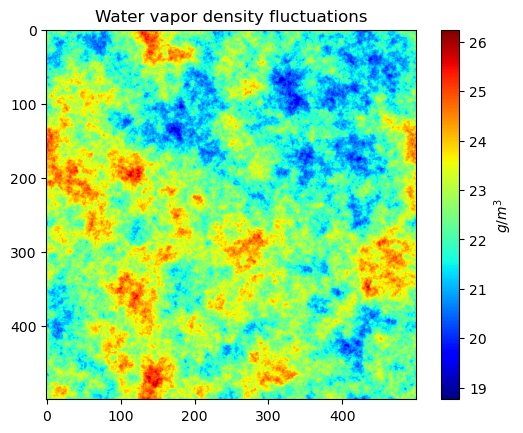

In [4]:
wv_fluctuations = atm.rho_map
print(wv_fluctuations.shape[0])
plt.imshow(wv_fluctuations, cmap='jet')
plt.title('Water vapor density fluctuations')
plt.colorbar(label=r'$g/m^{3}$')

In [5]:
atm.frequencies

array([134.05713053, 139.79146751, 145.7710926 , 152.00649808,
       158.50862505, 165.28888259, 196.61712478, 205.02748568,
       213.79760248, 222.94286386, 232.47931674, 242.42369446])

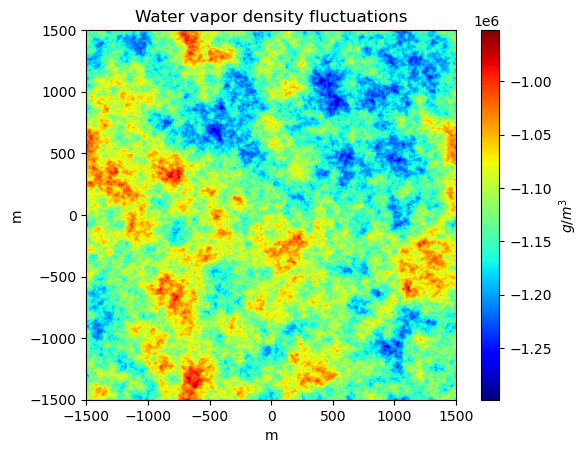

In [6]:
temp_fluctuations = np.zeros((wv_fluctuations.shape[0], wv_fluctuations.shape[1], 3))
temp_fluctuations[..., 0] = atm.get_temp_maps(wv_fluctuations)[0]
temp_fluctuations[..., 0] -= np.mean(temp_fluctuations[:, 0])

plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel(('m'))
plt.colorbar(label=r'$g/m^{3}$')

316.44761928968586 -58.75808063333319


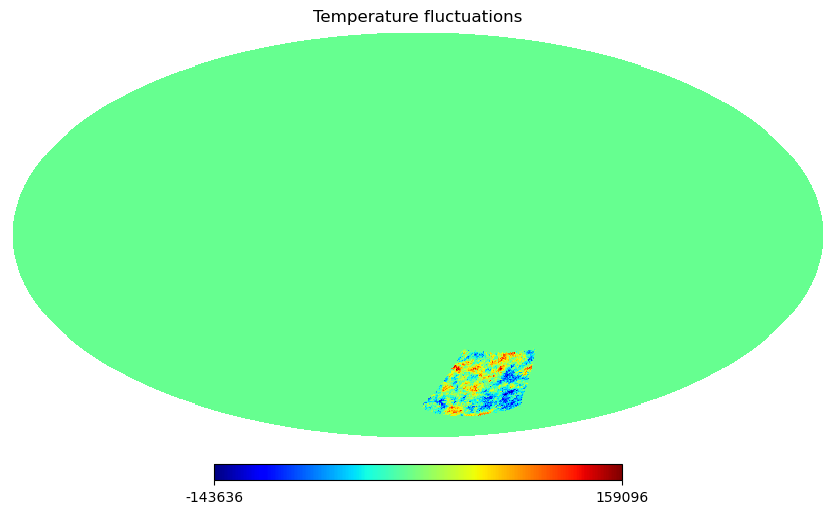

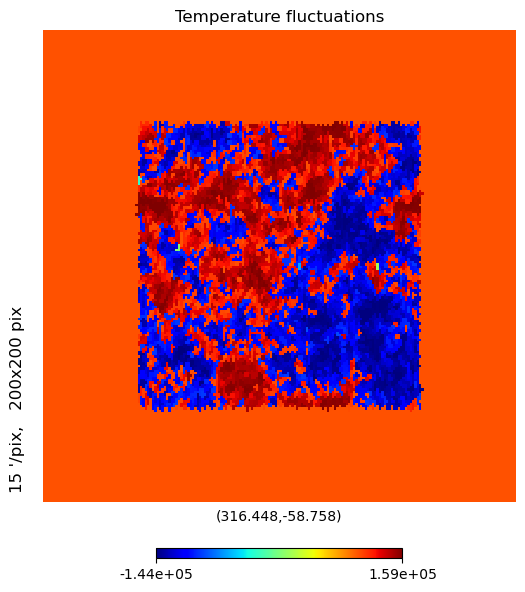

In [7]:
healpy_temp_fluctuations = np.zeros((hp.nside2npix(params['nside']), 3))
healpy_temp_fluctuations[..., 0] = atm.get_healpy_atm_maps_2d(atm.get_temp_maps(wv_fluctuations))[0]

index = np.where(healpy_temp_fluctuations!=0)[0]
healpy_temp_fluctuations[index, 0] -= np.mean(healpy_temp_fluctuations[index, 0])
min = np.min(healpy_temp_fluctuations[index, 0])
max = np.max(healpy_temp_fluctuations[index, 0])

hp.mollview(healpy_temp_fluctuations[..., 0], min=min, max=max, cmap='jet', title='Temperature fluctuations')
hp.gnomview(healpy_temp_fluctuations[..., 0], min=min, max=max, rot=equ2gal(0, -57), norm='hist', reso=15, cmap='jet', title='Temperature fluctuations')

In [8]:
print('Angular speed', qubic_dict['angspeed'])
print('Delta azimtuh', qubic_dict['delta_az'])
print('Sweeps per elevation', qubic_dict['nsweeps_per_elevation'])
print('Angular speed psi', qubic_dict['angspeed_psi'])
print('Maximum psi', qubic_dict['maxppsi'])
print('latitude', qubic_dict['latitude'])
print('longitude', qubic_dict['longitude'])
print('Fix_azimuth', qubic_dict['fix_azimuth'])
print('period', qubic_dict['period'])
print('duration', qubic_dict['duration'])
print('Observation date', qubic_dict['date_obs'], type(qubic_dict['date_obs']))

Angular speed 0.4
Delta azimtuh 20
Sweeps per elevation 1
Angular speed psi 0.1
Maximum psi None
latitude -24.183333333333334
longitude -66.46666666666667
Fix_azimuth {'apply': False, 'az': 50, 'el': 50, 'el_step': 1, 'fix_hwp': True, 'fix_pitch': True}
period 1
duration 20
Observation date 2016-01-01 00:00:00 <class 'str'>


# Scanning strategy

In [55]:
### Random pointing
qubic_dict['random_pointing'] = False

### Sweepingpointing
qubic_dict['sweeping_pointing'] = True
qubic_dict['fix_azimuth']['apply'] = False 
qubic_dict['duration'] = 1
qubic_dict['period'] = 1
qubic_dict['nsweeps_per_elevation'] = 1
qubic_dict['angspeed_psi'] = 0.001

### Repeat pointing
qubic_dict['repeat_pointing'] = False

q_sampling = get_pointing(qubic_dict)
print(q_sampling)

QubicSampling((3600,), 
    index=[   0    1    2 ... 3597 3598 3599],
    angle_hwp=[0. 0. 0. ... 0. 0. 0.],
    azimuth=[197.50277742 197.90498567 198.3071936  ... 204.70274928 204.3039,
    elevation=[49.1377017  49.1377017  49.1377017  ... 42.30525248 42.30525248
,
    equatorial=[[  9.25109027 -61.52346231]
 [  8.8069402  -61.37073712]
 [  8.3,
    galactic=[[305.97037497 -55.51955453]
 [306.37232587 -55.6490976 ]
 [306.7,
    masked=False,
    pitch=[-10.     -9.999  -9.998 ...  -6.403  -6.402  -6.401])


Text(0, 0.5, 'Elevation (deg)')

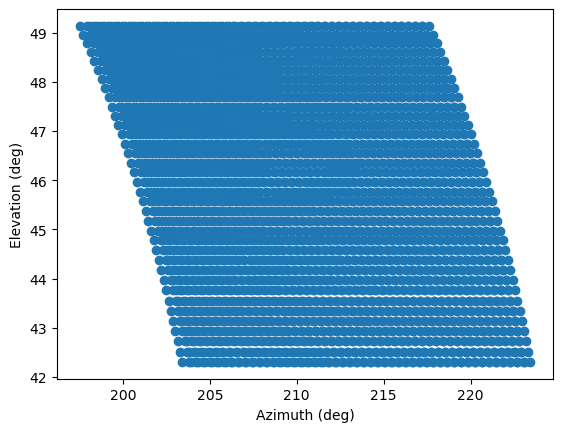

In [56]:
plt.plot(q_sampling.azimuth, q_sampling.elevation, 'o')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')

In [57]:
from pysimulators.interfaces.healpy import Spherical2HealpixOperator
from pysimulators import SphericalHorizontal2EquatorialOperator, SphericalEquatorial2GalacticOperator
from astropy.time import Time, TimeDelta

def _format_sphconv(a, b, date_obs=None, time=None):
    incoords = np.empty(np.broadcast(a, b).shape + (2,))
    incoords[..., 0] = a
    incoords[..., 1] = b
    if date_obs is None:
        return incoords
    time = Time(date_obs, scale='utc') + TimeDelta(time, format='sec')
    return incoords, time

incoords, time = _format_sphconv(q_sampling.azimuth, q_sampling.elevation, date_obs=qubic_dict['date_obs'], time=q_sampling.time)
h2e = SphericalHorizontal2EquatorialOperator(
        'NE', time, qubic_dict['latitude'], qubic_dict['longitude'], degrees=True)
e2g = SphericalEquatorial2GalacticOperator(degrees=True)
outcoords = e2g(h2e(incoords))

3600


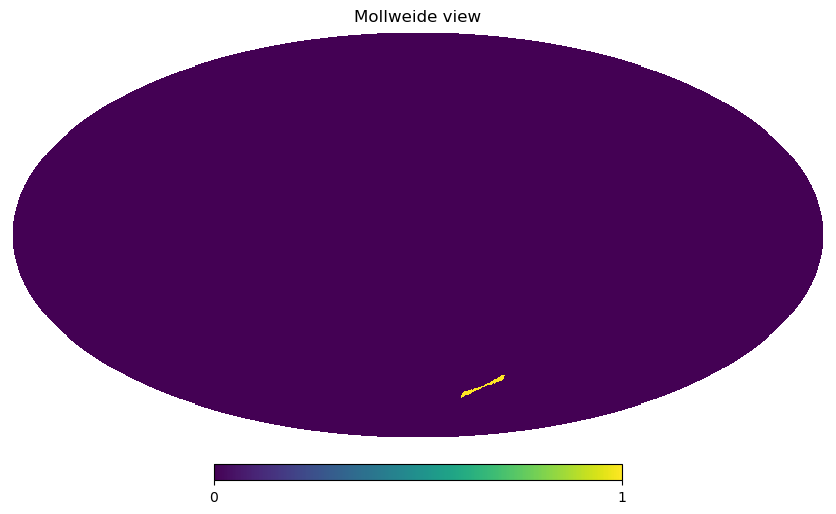

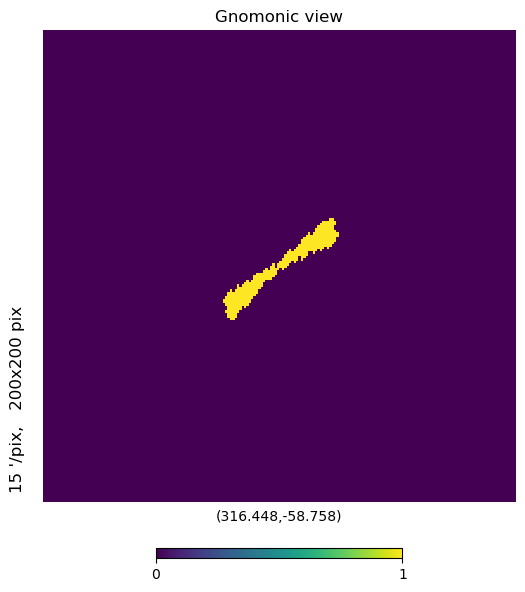

In [58]:
test = np.zeros(hp.nside2npix(params['nside']))
azel = np.asarray([q_sampling.azimuth, q_sampling.elevation]).T
index = np.array(Spherical2HealpixOperator(params['nside'], 'azimuth, elevation')(np.radians(outcoords)), dtype='int')
test[index] = 1
print(len(index))
hp.mollview(test)
hp.gnomview(test, rot=equ2gal(0, -57), reso=15)

# Wind

In [59]:
def random_wind(npointing, wind_mean, wind_std):
    wind_x = np.random.normal(wind_mean, wind_std, npointing)
    wind_y = np.random.normal(wind_mean, wind_std, npointing)
    
    return wind_x, wind_y

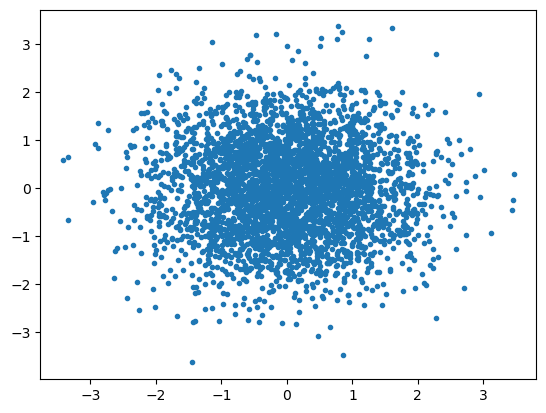

In [60]:
wind_x, wind_y = random_wind(len(q_sampling.index), 0, 1)

plt.plot(wind_x, wind_y, '.')

In [61]:
def azel_to_cartesian(azimuth, elevation, altitude):
    x = altitude / np.sin(elevation) * np.cos(elevation) * np.cos(azimuth)
    y = altitude / np.sin(elevation) * np.cos(elevation) * np.sin(azimuth)
    return x, y

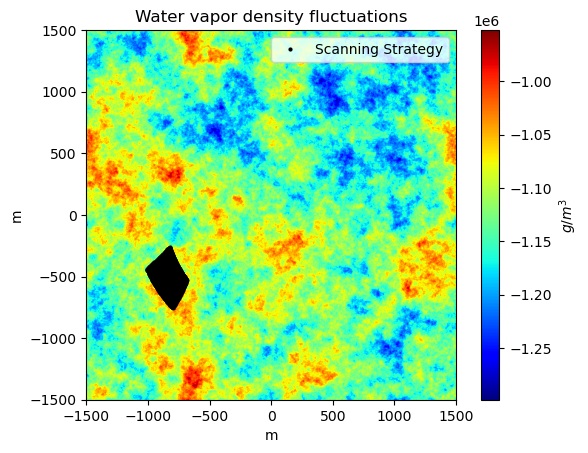

In [62]:
x, y = azel_to_cartesian(np.radians(q_sampling.azimuth), np.radians(q_sampling.elevation), params['altitude_atm_2d'])
plt.plot(x, y, 'ok', label='Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.legend()
plt.colorbar(label=r'$g/m^{3}$')

In [ ]:
Attention, il faut que j'ajoute le fait que le vent est en m/s, et qu'il y a du temps entre chaque point,
pour pouvoir calculer correctement le décalage dû au vent

def get_deviation_index(position_x, position_y, wind_x, wind_y, delta_time):
    deviated_index_x = (np.round(wind_x*delta_time) + np.round(position_x)).astype(int)
    deviated_index_y = (np.round(wind_y*delta_time) + np.round(position_y)).astype(int)
    return deviated_index_x, deviated_index_y
delta_time = qubic_dict['duration']*3600/qubic_dict['period']
deviated_index_x, deviated_index_y = get_deviation_index(x, y, wind_x, wind_y, delta_time)

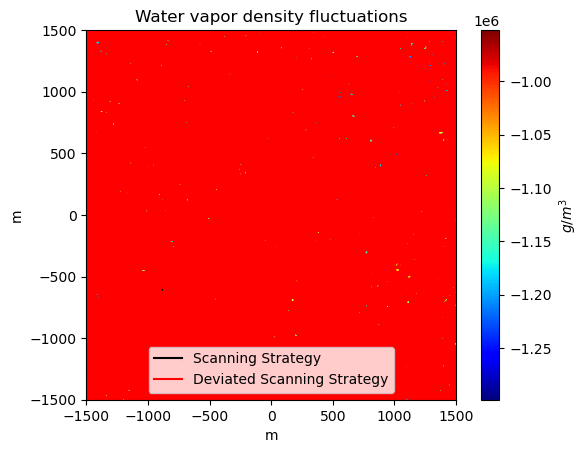

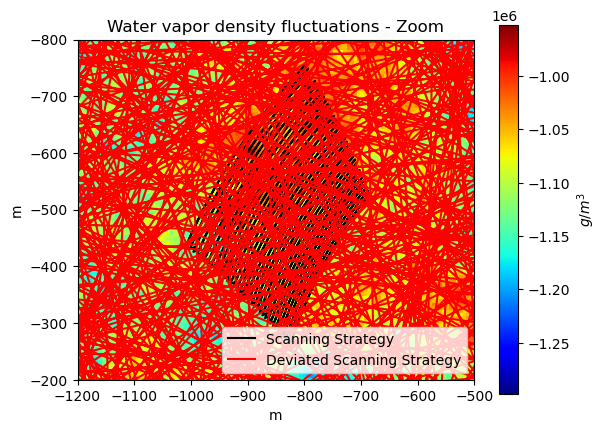

In [64]:
plt.figure()
plt.plot(x, y, 'k', label='Scanning Strategy', markersize=2)
plt.plot(deviated_index_x, deviated_index_y, 'r', label='Deviated Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations')
plt.xlabel('m')
plt.ylabel('m')
plt.legend()
plt.colorbar(label=r'$g/m^{3}$')

plt.figure()
plt.plot(x, y, 'k', label='Scanning Strategy', markersize=2)
plt.plot(deviated_index_x, deviated_index_y, 'r', label='Deviated Scanning Strategy', markersize=2)
plt.imshow(temp_fluctuations[..., 0], cmap='jet', extent=[-params['size_atm'], params['size_atm'], -params['size_atm'], params['size_atm']])
plt.title('Water vapor density fluctuations - Zoom')
plt.xlabel('m')
plt.ylabel('m')
plt.xlim(-1200, -500)
plt.ylim(-200, -800)
plt.legend()
plt.colorbar(label=r'$g/m^{3}$')

In [16]:
stop

NameError: name 'stop' is not defined

# Build MM

In [ ]:
q_instrument = QubicInstrument(qubic_dict)
q_scene = QubicScene(qubic_dict)

q_acquisition = QubicAcquisition(q_instrument, q_sampling, q_scene, qubic_dict)

In [ ]:
coverage = q_acquisition.get_coverage()

covnorm = coverage / coverage.max()
seenpix = covnorm > params['coverage_cut']

center = np.array([0, -57])
qubic_patch = qubic.lib.Qsamplings.equ2gal(center[0], center[1])

Info apcnb2325: Allocating (357120,9) elements = 49.04296875 MiB in FSRRotation3dMatrix.__init__.


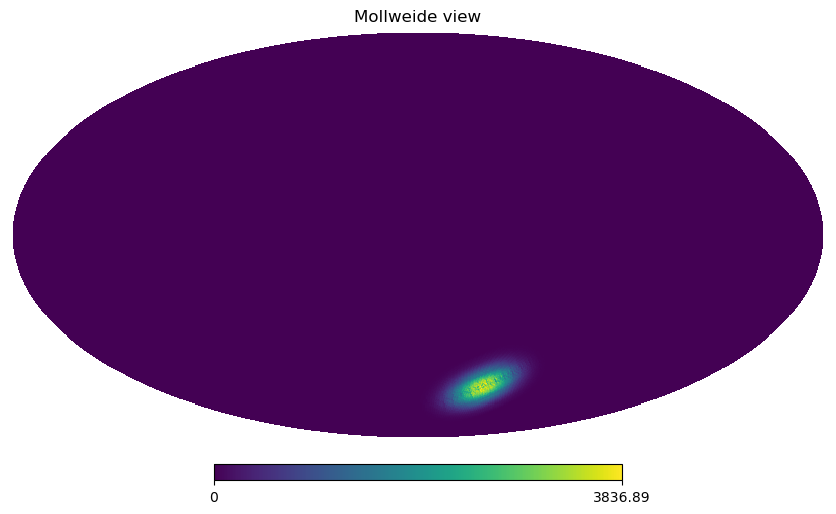

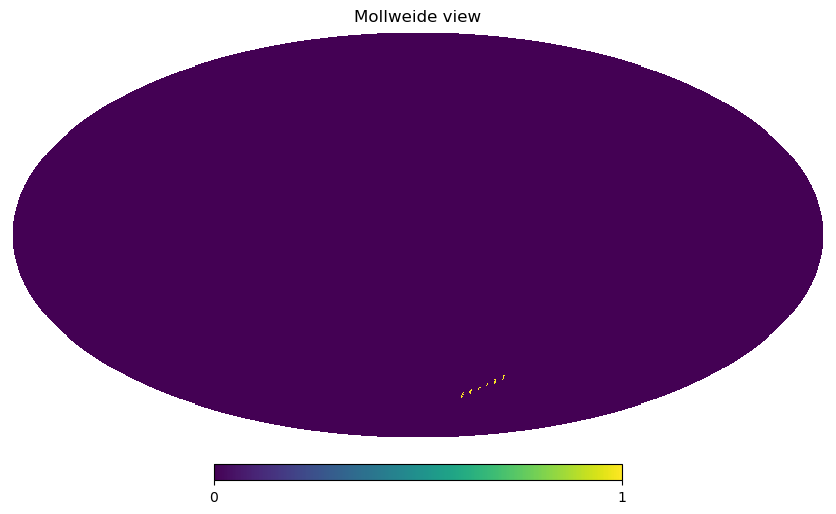

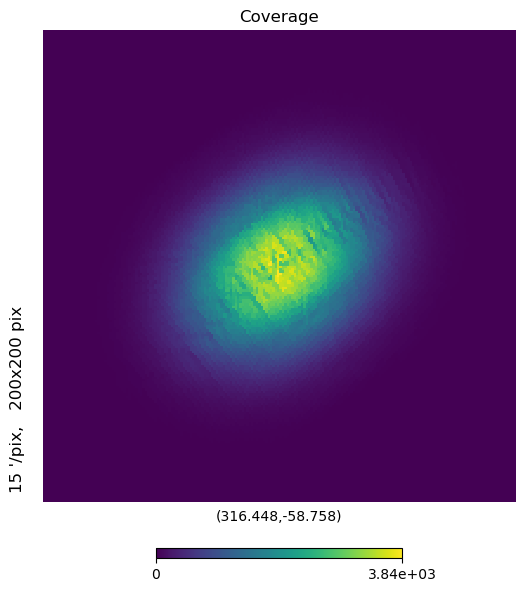

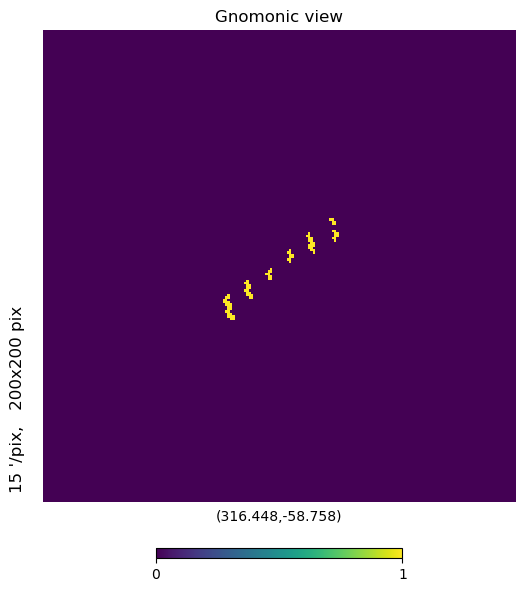

In [ ]:
hp.mollview(coverage)
hp.mollview(test)
hp.gnomview(coverage, rot=equ2gal(0, -57), reso=15, title='Coverage')
hp.gnomview(test, rot=equ2gal(0, -57), reso=15)

In [ ]:
H_qubic = q_acquisition.get_operator()
R_qubic = ReshapeOperator(H_qubic.shapeout, H_qubic.shape[0])
invN_qubic = R_qubic(q_acquisition.get_invntt_operator(False, False)(R_qubic.T))
d_qubic = H_qubic(healpy_temp_fluctuations).ravel()

Info apcnb2325: Allocating (357120,9) elements = 49.04296875 MiB in FSRRotation3dMatrix.__init__.


In [ ]:
H = R_qubic(H_qubic)
invN = invN_qubic
d = d_qubic

In [ ]:
A = H.T * invN * H
b = H.T * invN * d.flatten()
x0 = healpy_temp_fluctuations*0
true_maps = healpy_temp_fluctuations

In [ ]:
stacked_dptdp_inv = np.zeros((1,12*params['nside']**2))

D = H.operands[2]
P = H.operands[-1]
sh = P.matrix.data.index.shape
no_det = 992
point_per_det = int(sh[0] / no_det)
mapPtP_perdet_seq = np.zeros((no_det, 12 * params['nside']**2))
sample_ranges = [(det * point_per_det, (det + 1) * point_per_det) for det in range(no_det)]
for det, (start, end) in enumerate(sample_ranges):
    indices = P.matrix.data.index[start:end, :]  
    weights = P.matrix.data.r11[start:end, :]
    flat_indices = indices.ravel()
    flat_weights = weights.ravel()

    mapPitPi = np.zeros(12 * params['nside']**2)
    np.add.at(mapPitPi, flat_indices, flat_weights**2)

    mapPtP_perdet_seq[det, :] = mapPitPi
D_elements = D.data
D_sq = D_elements**2
mapPtP_seq_scaled = D_sq[:, np.newaxis] * mapPtP_perdet_seq 
dptdp = mapPtP_seq_scaled.sum(axis = 0)
dptdp_inv = 1 / dptdp
dptdp_inv[np.isinf(dptdp_inv)] = 0.
stacked_dptdp_inv[0] = dptdp_inv
M = BlockDiagonalOperator( \
            [DiagonalOperator(ci, broadcast='rightward') for ci in stacked_dptdp_inv],
            new_axisin=0)

# Map-Making

In [ ]:
# Run PCG
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-10,
    maxiter=200,
    disp=True,
    M=M,
    center=[0, -57],
    reso=15,
    seenpix=seenpix,
    input=true_maps,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

2
 Iter     Tol      time
   1: 3.0681e-01 0.03639 [19381.41048371 15678.4276111   3189.73263617 ... 18361.86802708
  5677.9713017   9124.50958214]
2
   2: 1.7430e-01 0.03351 [20546.15267467 17947.1078616   9121.82540807 ... 12948.35410321
  5568.17148043  8311.0643339 ]
2
   3: 9.3882e-02 0.03278 [20636.05619075 18204.29641244 10791.93521622 ...  8776.65200014
  4079.97654827  6424.98024811]
2
   4: 5.7341e-02 0.02974 [17940.57683496 15427.8707027   8900.83946862 ...  9864.24314901
  6600.56297307 10603.41740073]
2
   5: 4.4337e-02 0.02758 [17764.28693149 16630.10813113 12648.88237635 ...  7517.55038281
  5424.11876703  8152.44258767]
2
   6: 4.1329e-02 0.02803 [14577.9348735  14531.18297219 13397.35652483 ...  6483.56611108
  3976.85068459  6153.73486187]
2
   7: 2.5979e-02 0.02856 [13015.99332598 13449.19040045 14439.24133777 ...  7303.77907793
  4129.2006225   6243.1490613 ]
2
   8: 2.2779e-02 0.03019 [11267.55764354 11935.11546297 14163.28866338 ...  6941.31184514
  3851.28710512 

Text(0, 0.5, 'Convergence')

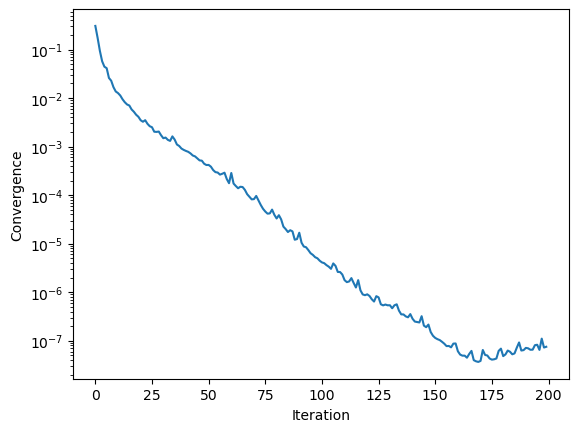

In [ ]:
plt.plot(output['convergence'])
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Convergence')

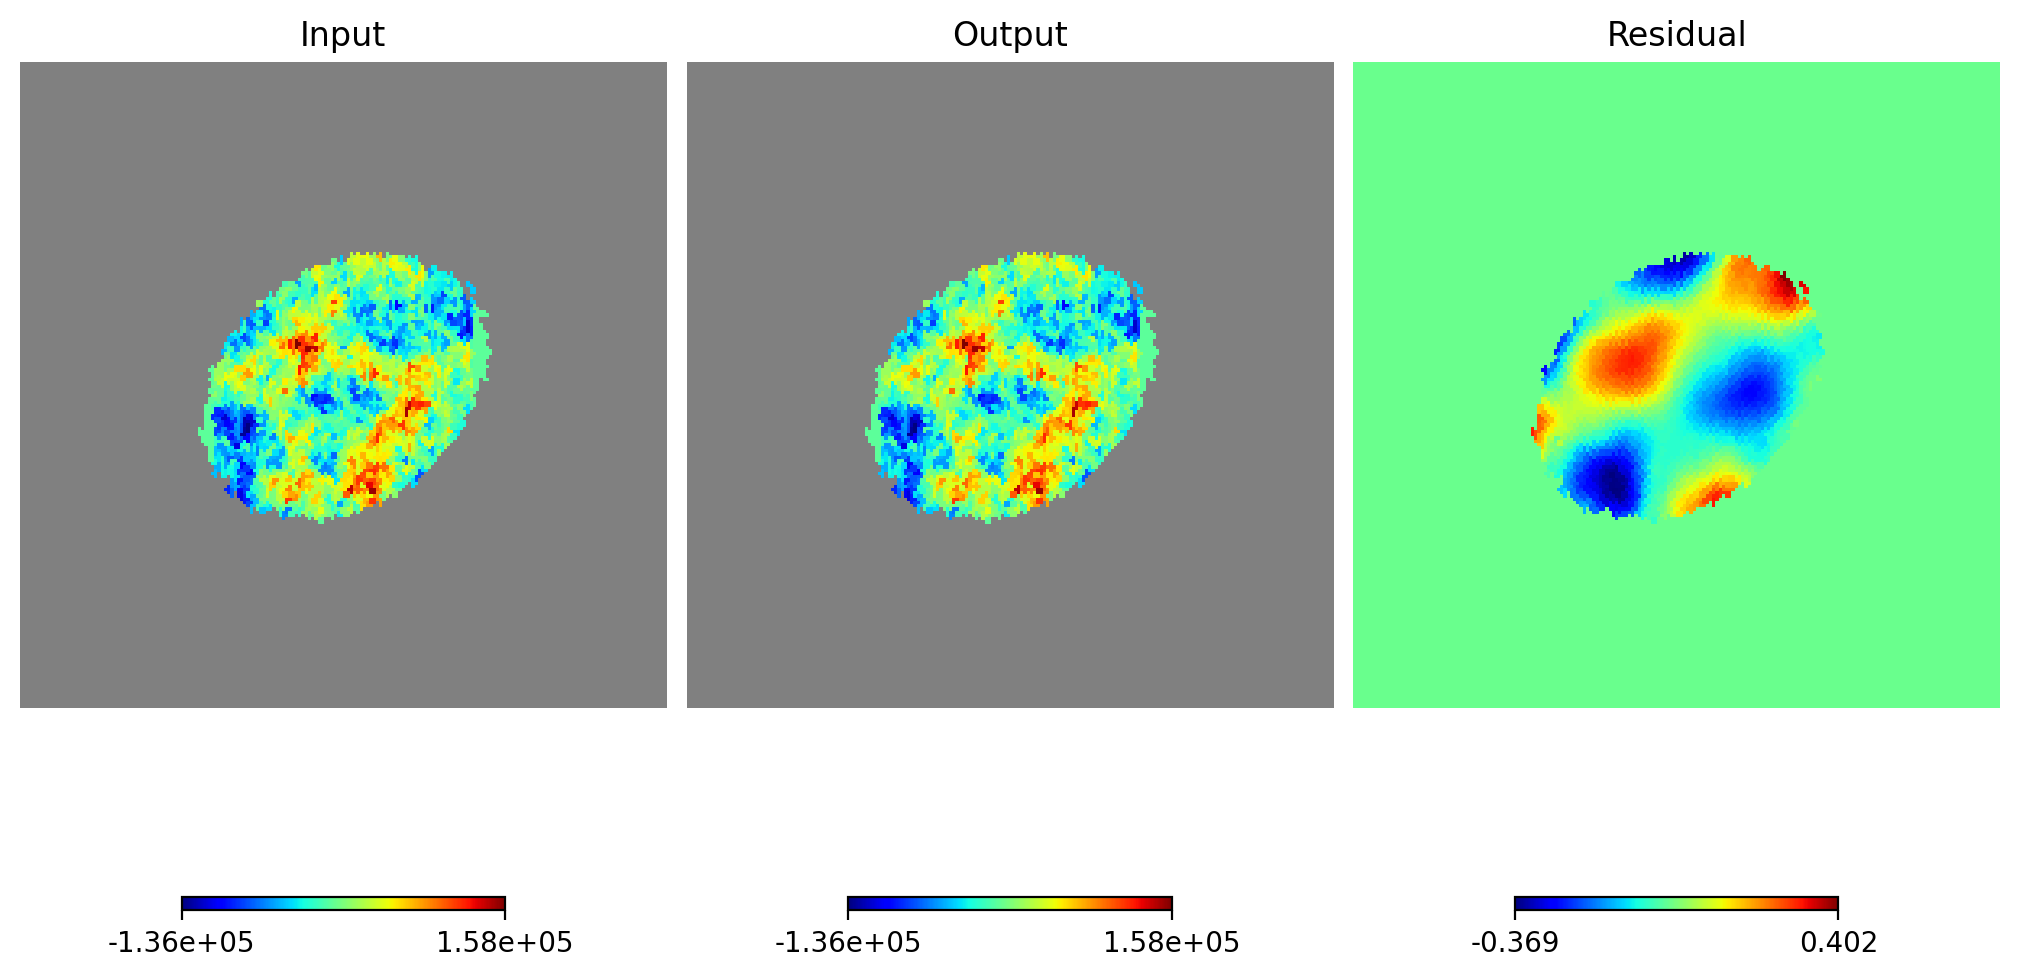

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

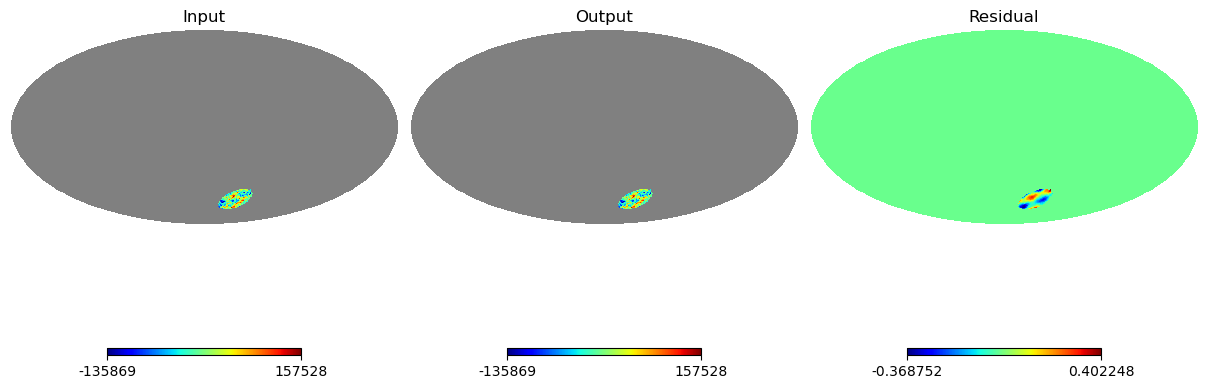

In [ ]:
plt.figure(figsize=(12, 25))
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 0
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.mollview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k), title='Input', notext=True)
hp.mollview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', sub=(1, 3, k+1), title='Output', notext=True)
hp.mollview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', sub=(1, 3, k+2), title='Residual', notext=True)
k+=3

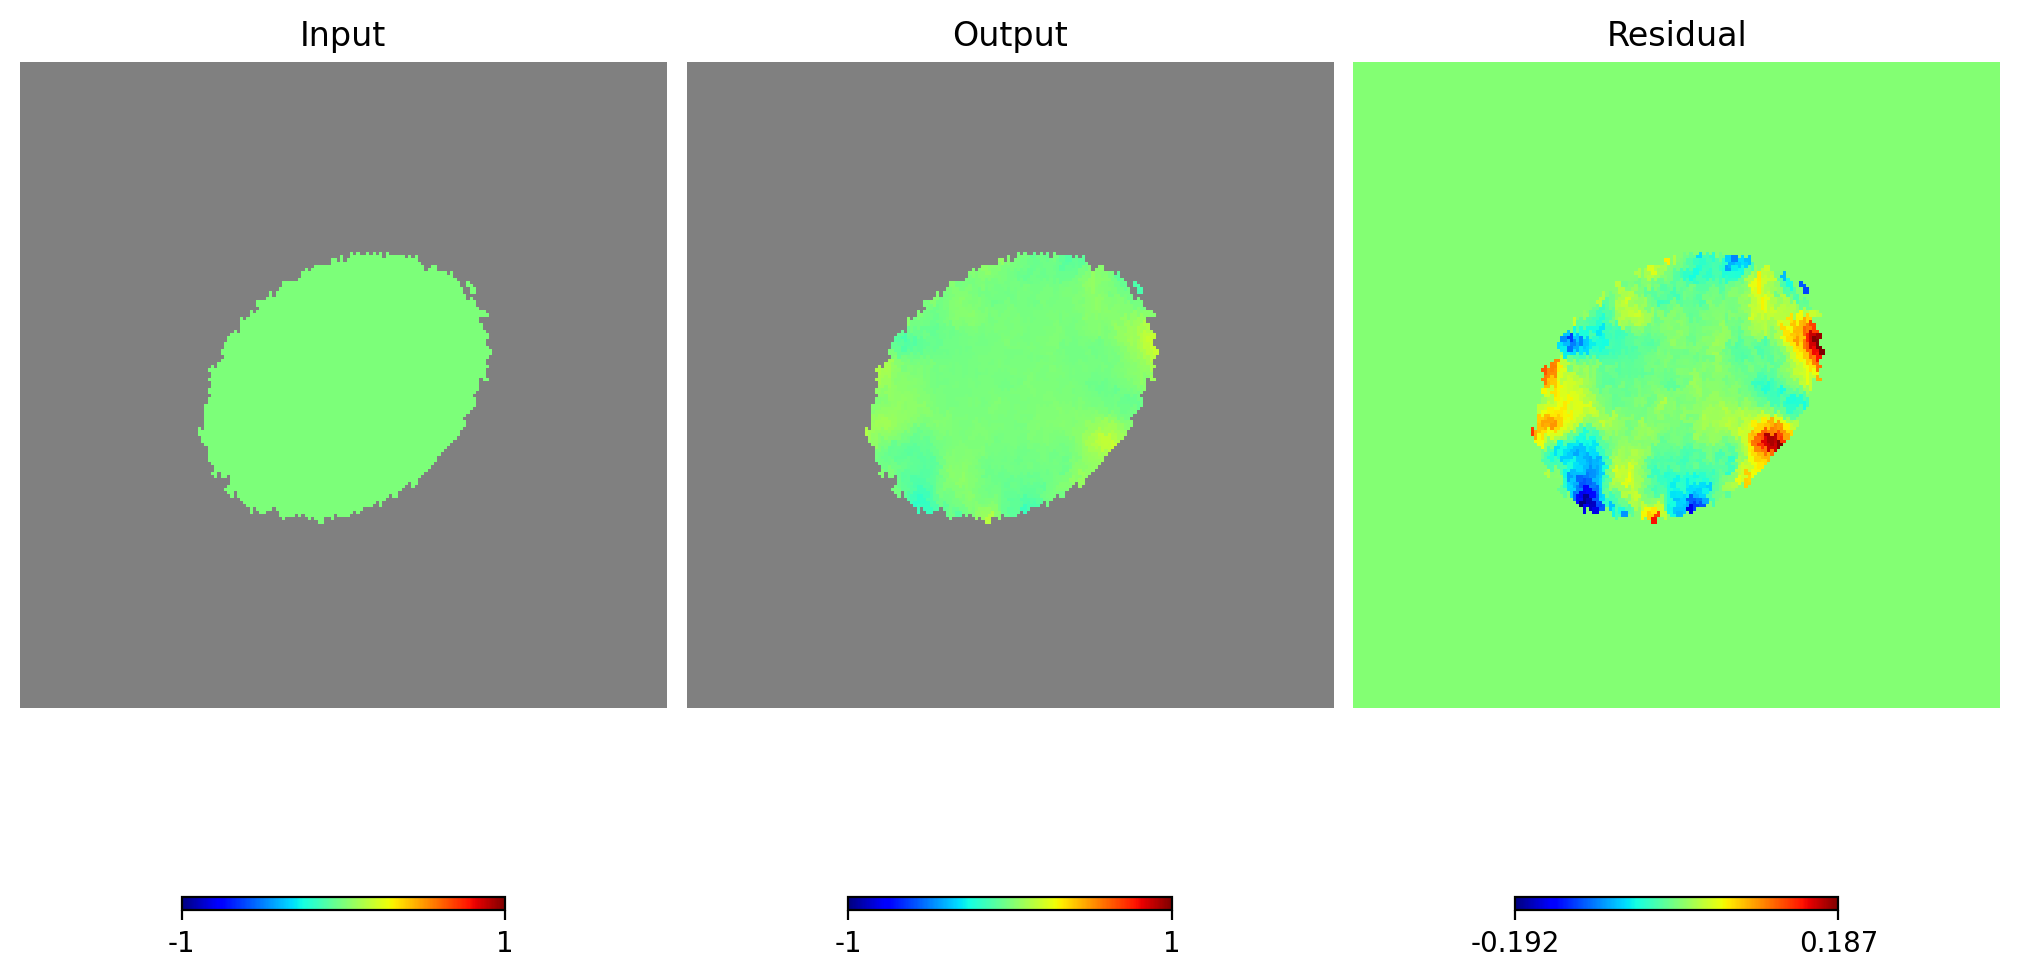

In [ ]:
plt.figure(figsize=(10, 12), dpi=200)
k=1
true_maps[~seenpix, :] = hp.UNSEEN
output['x'][~seenpix, :] = hp.UNSEEN

istk = 1
n_sig = 3

sigma = np.std(true_maps[seenpix, istk])
hp.gnomview(true_maps[:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k), title='Input', notext=True)
hp.gnomview(output['x'][:, istk], min=np.min(true_maps[seenpix, istk]), max=np.max(true_maps[seenpix, istk]), cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+1), title='Output', notext=True)
hp.gnomview(output['x'][:, istk] - true_maps[:, istk], cmap='jet', rot=qubic_patch, reso=15, sub=(1, 3, k+2), title='Residual', notext=True)
k+=3